In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import torchvision
import numpy as np
from torch.autograd import Variable
from torch.optim import lr_scheduler
import argparse

import time
import copy
from torchvision.utils import save_image
import gc

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd /content/drive/MyDrive/ECE1512ProjB

/content/drive/MyDrive/ECE1512ProjB


In [ ]:
from networks import MLP, ConvNet, LeNet, AlexNet, AlexNetBN, VGG11, VGG11BN, ResNet18, ResNet18BN_AP, ResNet18BN
from utils import get_loops, get_dataset, get_network, get_eval_pool, evaluate_synset, get_daparam, match_loss, get_time, TensorDataset, epoch, DiffAugment, ParamDiffAug

# Dataset Condensation and Visualization

In [ ]:
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--method', type=str, default='DC', help='DC/DSA')
parser.add_argument('--dataset', type=str, default='CIFAR10', help='dataset')
parser.add_argument('--model', type=str, default='ConvNet', help='model')
parser.add_argument('--ipc', type=int, default=10, help='image(s) per class')
parser.add_argument('--eval_mode', type=str, default='S', help='eval_mode') # S: the same to training model, M: multi architectures,  W: net width, D: net depth, A: activation function, P: pooling layer, N: normalization layer,
parser.add_argument('--num_exp', type=int, default=5, help='the number of experiments')
parser.add_argument('--num_eval', type=int, default=20, help='the number of evaluating randomly initialized models')
parser.add_argument('--epoch_eval_train', type=int, default=300, help='epochs to train a model with synthetic data')
parser.add_argument('--Iteration', type=int, default=100, help='training iterations')
parser.add_argument('--lr_img', type=float, default=0.1, help='learning rate for updating synthetic images')
parser.add_argument('--lr_net', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--batch_real', type=int, default=256, help='batch size for real data')
parser.add_argument('--batch_train', type=int, default=256, help='batch size for training networks')
parser.add_argument('--init', type=str, default='noise', help='noise/real: initialize synthetic images from random noise or randomly sampled real images.')
parser.add_argument('--dsa_strategy', type=str, default='None', help='differentiable Siamese augmentation strategy')
parser.add_argument('--data_path', type=str, default='data', help='dataset path')
parser.add_argument('--save_path', type=str, default='result', help='path to save results')
parser.add_argument('--dis_metric', type=str, default='ours', help='distance metric')

args, unknown = parser.parse_known_args()
args.init = 'real'
args.dataset = 'MNIST'
args.outer_loop, args.inner_loop = get_loops(args.ipc)
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = True if args.method == 'DSA' else False

if not os.path.exists(args.data_path):
  os.mkdir(args.data_path)

if not os.path.exists(args.save_path):
  os.mkdir(args.save_path)

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(args.dataset, args.data_path)

''' organize the real dataset '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]

for i, lab in enumerate(labels_all):
  indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args.device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args.device)

for c in range(num_classes):
  print('class c = %d: %d real images'%(c, len(indices_class[c])))

def get_images(c, n): # get random n images from class c
  idx_shuffle = np.random.permutation(indices_class[c])[:n]
  return images_all[idx_shuffle]

for ch in range(channel):
  print('real images channel %d, mean = %.4f, std = %.4f'%(ch, torch.mean(images_all[:, ch]), torch.std(images_all[:, ch])))


''' initialize the synthetic data '''
image_syn = torch.randn(size=(num_classes*args.ipc, channel, im_size[0], im_size[1]), dtype=torch.float, requires_grad=True, device=args.device)
label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]

if args.init == 'real':
  print('initialize synthetic data from random real images')
  for c in range(num_classes):
    image_syn.data[c*args.ipc:(c+1)*args.ipc] = get_images(c, args.ipc).detach().data
else:
  print('initialize synthetic data from random noise')

''' training '''
optimizer_img = torch.optim.SGD([image_syn, ], lr=args.lr_img, momentum=0.5) # optimizer_img for synthetic data
optimizer_img.zero_grad()
criterion = nn.CrossEntropyLoss().to(args.device)
print('%s training begins'%get_time())


for it in range(args.Iteration+1):
  

  ''' Train synthetic data '''
  net = get_network(args.model, channel, num_classes, im_size).to(args.device) # get a random model
  net.train()
  net_parameters = list(net.parameters())
  optimizer_net = torch.optim.SGD(net.parameters(), lr=args.lr_net)  # optimizer_img for synthetic data
  optimizer_net.zero_grad()
  loss_avg = 0
  args.dc_aug_param = None  # Mute the DC augmentation when learning synthetic data (in inner-loop epoch function) in oder to be consistent with DC paper.
  
  for ol in range(args.outer_loop): # ol = 10, il = 50 (T)

    ''' update synthetic data '''
    loss = torch.tensor(0.0).to(args.device)
    for c in range(num_classes):
      img_real = get_images(c, args.batch_real)
      lab_real = torch.ones((img_real.shape[0],), device=args.device, dtype=torch.long) * c
      img_syn = image_syn[c*args.ipc:(c+1)*args.ipc].reshape((args.ipc, channel, im_size[0], im_size[1]))
      lab_syn = torch.ones((args.ipc,), device=args.device, dtype=torch.long) * c
      
      output_real = net(img_real)
      loss_real = criterion(output_real, lab_real)
      gw_real = torch.autograd.grad(loss_real, net_parameters)
      gw_real = list((_.detach().clone() for _ in gw_real))

      output_syn = net(img_syn)
      loss_syn = criterion(output_syn, lab_syn)
      gw_syn = torch.autograd.grad(loss_syn, net_parameters, create_graph=True)

      loss += match_loss(gw_syn, gw_real, args)

    optimizer_img.zero_grad()
    loss.backward()
    optimizer_img.step()
    loss_avg += loss.item()

    if ol == args.outer_loop - 1:
      break

      ''' update network '''
      image_syn_train, label_syn_train = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach())  # avoid any unaware modification
      dst_syn_train = TensorDataset(image_syn_train, label_syn_train)
      trainloader = torch.utils.data.DataLoader(dst_syn_train, batch_size=args.batch_train, shuffle=True, num_workers=0)
      for il in range(args.inner_loop):
        epoch('train', trainloader, net, optimizer_net, criterion, args, aug = True if args.dsa else False)
  loss_avg /= (num_classes*args.outer_loop)
  

  if it%10 == 0:
    print('%s iter = %04d, loss = %.4f' % (get_time(), it, loss_avg))
    
    ''' Test '''  
    accs = []
    image_syn_eval, label_syn_eval = copy.deepcopy(image_syn.detach()), copy.deepcopy(label_syn.detach()) # avoid any unaware modification
    _, acc_train, acc_test = evaluate_synset(1, net, image_syn_eval, label_syn_eval, testloader, args)
    accs.append(acc_test)

class c = 0: 5923 real images
class c = 1: 6742 real images
class c = 2: 5958 real images
class c = 3: 6131 real images
class c = 4: 5842 real images
class c = 5: 5421 real images
class c = 6: 5918 real images
class c = 7: 6265 real images
class c = 8: 5851 real images
class c = 9: 5949 real images
real images channel 0, mean = -0.0001, std = 1.0000
initialize synthetic data from random real images
[2022-12-09 20:32:57] training begins


<ipython-input-5-cbe6470b2486>:63: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]
<ipython-input-5-cbe6470b2486>:63: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  label_syn = torch.tensor([np.ones(args.ipc)*i for i in range(num_classes)], dtype=torch.long, requires_grad=False, device=args.device).view(-1) # [0,0,0, 1,1,1, ..., 9,9,9]


[2022-12-09 20:33:08] iter = 0000, loss = 23.5768
[2022-12-09 20:33:14] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003829 train acc = 1.0000, test acc = 0.9142
[2022-12-09 20:33:54] iter = 0010, loss = 21.7895
[2022-12-09 20:34:00] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003819 train acc = 1.0000, test acc = 0.9272
[2022-12-09 20:34:39] iter = 0020, loss = 18.8300
[2022-12-09 20:34:45] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003768 train acc = 1.0000, test acc = 0.9246
[2022-12-09 20:35:25] iter = 0030, loss = 17.4129
[2022-12-09 20:35:31] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.004006 train acc = 1.0000, test acc = 0.9267
[2022-12-09 20:36:11] iter = 0040, loss = 15.8160
[2022-12-09 20:36:17] Evaluate_01: epoch = 0300 train time = 3 s train loss = 0.003860 train acc = 1.0000, test acc = 0.9302
[2022-12-09 20:36:56] iter = 0050, loss = 15.5233
[2022-12-09 20:37:02] Evaluate_01: epoch = 0300 train time = 3 s train loss

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]


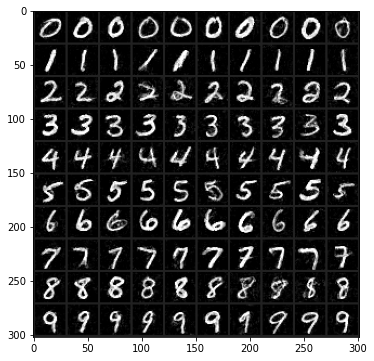

In [ ]:
mean = [0.1307]
std = [0.3081]
# images, labels = next(iter(data_loader_train))
dataset_syn = torchvision.utils.make_grid(image_syn, nrow=10).cpu()
dataset_syn = dataset_syn.numpy().transpose(1,2,0)
dataset_syn = dataset_syn*std+mean
print([int(label_syn[i]) for i in range(100)])
plt.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(dataset_syn)

#Continual learning task

In [ ]:
#Without our dataset
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--method', type=str, default='random', help='random/herding/DSA/DM')
parser.add_argument('--dataset', type=str, default='MNIST', help='dataset')
parser.add_argument('--model', type=str, default='ConvNet', help='model')
parser.add_argument('--ipc', type=int, default=10, help='image(s) per class')
parser.add_argument('--steps', type=int, default=5, help='5/10-step learning')
parser.add_argument('--num_eval', type=int, default=3, help='evaluation number')
parser.add_argument('--epoch_eval_train', type=int, default=100, help='epochs to train a model with synthetic data')
parser.add_argument('--lr_net', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--batch_train', type=int, default=256, help='batch size for training networks')
parser.add_argument('--data_path', type=str, default='./../data', help='dataset path')

args, unknown = parser.parse_known_args()
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = True # augment images for all methods
args.dsa_strategy = 'color_crop_cutout_flip_scale_rotate' # for CIFAR10/100

if not os.path.exists(args.data_path):
    os.mkdir(args.data_path)

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(args.dataset, args.data_path)


''' all training data '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args.device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args.device)

# for c in range(num_classes):
#     print('class c = %d: %d real images' % (c, len(indices_class[c])))

def get_images(c, n):  # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

print()
print('==================================================================================')
print('method: ', args.method)
results = np.zeros((args.steps, 5*args.num_eval))

num_classes_step = num_classes // args.steps
np.random.seed(0)
class_order = np.random.permutation(num_classes).tolist()

if args.method == 'random':
    images_train_all = []
    labels_train_all = []
    for step in range(args.steps):
        classes_current = class_order[step * num_classes_step: (step + 1) * num_classes_step]
        images_train_all += [torch.cat([get_images(c, args.ipc) for c in classes_current], dim=0)]
        labels_train_all += [torch.tensor([c for c in classes_current for i in range(args.ipc)], dtype=torch.long, device=args.device)]

elif args.method == 'herding':
    fname = os.path.join(args.data_path, 'metasets', 'cl_data', 'cl_herding_CIFAR100_ConvNet_20ipc_%dsteps_seed%d.pt'%(args.steps, seed_cl))
    data = torch.load(fname, map_location='cpu')['data']
    images_train_all = [data[step][0] for step in range(args.steps)]
    labels_train_all = [data[step][1] for step in range(args.steps)]
    print('use data: ', fname)

elif args.method == 'DSA':
    fname = os.path.join(args.data_path, 'metasets', 'cl_data', 'cl_res_DSA_CIFAR100_ConvNet_20ipc_%dsteps_seed%d.pt'%(args.steps, seed_cl))
    data = torch.load(fname, map_location='cpu')['data']
    images_train_all = [data[step][0] for step in range(args.steps)]
    labels_train_all = [data[step][1] for step in range(args.steps)]
    print('use data: ', fname)

elif args.method == 'DM':
    fname = os.path.join(args.data_path, 'metasets', 'cl_data', 'cl_DM_CIFAR100_ConvNet_20ipc_%dsteps_seed%d.pt'%(args.steps, seed_cl))
    data = torch.load(fname, map_location='cpu')['data']
    images_train_all = [data[step][0] for step in range(args.steps)]
    labels_train_all = [data[step][1] for step in range(args.steps)]
    print('use data: ', fname)

else:
    exit('unknown method: %s'%args.method)


for step in range(args.steps):

    classes_seen = class_order[: (step+1)*num_classes_step]
    print('classes_seen: ', classes_seen)


    ''' train data '''
    images_train = torch.cat(images_train_all[:step+1], dim=0).to(args.device)
    labels_train = torch.cat(labels_train_all[:step+1], dim=0).to(args.device)
    print('train data size: ', images_train.shape)


    ''' test data '''
    images_test = []
    labels_test = []
    for i in range(len(dst_test)):
        lab = int(dst_test[i][1])
        if lab in classes_seen:
            images_test.append(torch.unsqueeze(dst_test[i][0], dim=0))
            labels_test.append(dst_test[i][1])

    images_test = torch.cat(images_test, dim=0).to(args.device)
    labels_test = torch.tensor(labels_test, dtype=torch.long, device=args.device)
    dst_test_current = TensorDataset(images_test, labels_test)
    testloader = torch.utils.data.DataLoader(dst_test_current, batch_size=256, shuffle=False, num_workers=0)

    print('test set size: ', images_test.shape)


    ''' train model on the newest memory '''
    accs = []
    for ep_eval in range(args.num_eval):
        net_eval = get_network(args.model, channel, num_classes, im_size)
        net_eval = net_eval.to(args.device)
        img_syn_eval = copy.deepcopy(images_train.detach())
        lab_syn_eval = copy.deepcopy(labels_train.detach())

        _, acc_train, acc_test = evaluate_synset(ep_eval, net_eval, img_syn_eval, lab_syn_eval, testloader, args)
        del net_eval, img_syn_eval, lab_syn_eval
        gc.collect()  # to reduce memory cost
        accs.append(acc_test)
        results[step, 0*args.num_eval + ep_eval] = acc_test
    print('Evaluate %d random %s, mean = %.4f std = %.4f' % (len(accs), args.model, np.mean(accs), np.std(accs)))


results_str = ''
for step in range(args.steps):
    results_str += '& %.1f$\pm$%.1f  ' % (np.mean(results[step]) * 100, np.std(results[step]) * 100)
print('\n\n')
print('%d step learning %s perforamnce:'%(args.steps, args.method))
print(results_str)
print('Done')



method:  random
classes_seen:  [2, 8]
train data size:  torch.Size([20, 1, 28, 28])
test set size:  torch.Size([2006, 1, 28, 28])
[2022-12-09 21:06:39] Evaluate_00: epoch = 0100 train time = 0 s train loss = 0.001034 train acc = 1.0000, test acc = 0.9661
[2022-12-09 21:06:40] Evaluate_01: epoch = 0100 train time = 0 s train loss = 0.001277 train acc = 1.0000, test acc = 0.9731
[2022-12-09 21:06:40] Evaluate_02: epoch = 0100 train time = 0 s train loss = 0.386097 train acc = 0.8500, test acc = 0.9726
Evaluate 3 random ConvNet, mean = 0.9706 std = 0.0032
classes_seen:  [2, 8, 4, 9]
train data size:  torch.Size([40, 1, 28, 28])
test set size:  torch.Size([3997, 1, 28, 28])
[2022-12-09 21:06:46] Evaluate_00: epoch = 0100 train time = 0 s train loss = 0.010375 train acc = 1.0000, test acc = 0.9167
[2022-12-09 21:06:47] Evaluate_01: epoch = 0100 train time = 0 s train loss = 0.042215 train acc = 1.0000, test acc = 0.9062
[2022-12-09 21:06:47] Evaluate_02: epoch = 0100 train time = 0 s train

In [ ]:
#Using our dataset
parser = argparse.ArgumentParser(description='Parameter Processing')
parser.add_argument('--method', type=str, default='random', help='random/herding/DSA/DM')
parser.add_argument('--dataset', type=str, default='MNIST', help='dataset')
parser.add_argument('--model', type=str, default='ConvNet', help='model')
parser.add_argument('--ipc', type=int, default=10, help='image(s) per class')
parser.add_argument('--steps', type=int, default=5, help='5/10-step learning')
parser.add_argument('--num_eval', type=int, default=3, help='evaluation number')
parser.add_argument('--epoch_eval_train', type=int, default=100, help='epochs to train a model with synthetic data')
parser.add_argument('--lr_net', type=float, default=0.01, help='learning rate for updating network parameters')
parser.add_argument('--batch_train', type=int, default=256, help='batch size for training networks')
parser.add_argument('--data_path', type=str, default='./../data', help='dataset path')

args, unknown = parser.parse_known_args()
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.dsa_param = ParamDiffAug()
args.dsa = True # augment images for all methods
args.dsa_strategy = 'color_crop_cutout_flip_scale_rotate' # for CIFAR10/100

if not os.path.exists(args.data_path):
    os.mkdir(args.data_path)

channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset(args.dataset, args.data_path)


''' all training data '''
images_all = []
labels_all = []
indices_class = [[] for c in range(num_classes)]

images_all = [torch.unsqueeze(dst_train[i][0], dim=0) for i in range(len(dst_train))]
labels_all = [dst_train[i][1] for i in range(len(dst_train))]
for i, lab in enumerate(labels_all):
    indices_class[lab].append(i)
images_all = torch.cat(images_all, dim=0).to(args.device)
labels_all = torch.tensor(labels_all, dtype=torch.long, device=args.device)

# for c in range(num_classes):
#     print('class c = %d: %d real images' % (c, len(indices_class[c])))

def get_images(c, n):  # get random n images from class c
    idx_shuffle = np.random.permutation(indices_class[c])[:n]
    return images_all[idx_shuffle]

print()
print('==================================================================================')
print('method: ', args.method)
results = np.zeros((args.steps, 5*args.num_eval))

num_classes_step = num_classes // args.steps
np.random.seed(0)
class_order = np.random.permutation(num_classes).tolist()

#Apply our dataset during training
images_train_all = image_syn
labels_train_all = label_syn

for step in range(args.steps):

    classes_seen = class_order[: (step+1)*num_classes_step]
    print('classes_seen: ', classes_seen)


    ''' train data '''
    images_train = images_train_all.to(args.device)
    labels_train = labels_train_all.to(args.device)
    print('train data size: ', images_train.shape)


    ''' test data '''
    images_test = []
    labels_test = []
    for i in range(len(dst_test)):
        lab = int(dst_test[i][1])
        if lab in classes_seen:
            images_test.append(torch.unsqueeze(dst_test[i][0], dim=0))
            labels_test.append(dst_test[i][1])

    images_test = torch.cat(images_test, dim=0).to(args.device)
    labels_test = torch.tensor(labels_test, dtype=torch.long, device=args.device)
    dst_test_current = TensorDataset(images_test, labels_test)
    testloader = torch.utils.data.DataLoader(dst_test_current, batch_size=256, shuffle=False, num_workers=0)

    print('test set size: ', images_test.shape)


    ''' train model on the newest memory '''
    accs = []
    for ep_eval in range(args.num_eval):
        net_eval = get_network(args.model, channel, num_classes, im_size)
        net_eval = net_eval.to(args.device)
        img_syn_eval = copy.deepcopy(images_train.detach())
        lab_syn_eval = copy.deepcopy(labels_train.detach())

        _, acc_train, acc_test = evaluate_synset(ep_eval, net_eval, img_syn_eval, lab_syn_eval, testloader, args)
        del net_eval, img_syn_eval, lab_syn_eval
        gc.collect()  # to reduce memory cost
        accs.append(acc_test)
        results[step, 0*args.num_eval + ep_eval] = acc_test
    print('Evaluate %d random %s, mean = %.4f std = %.4f' % (len(accs), args.model, np.mean(accs), np.std(accs)))


results_str = ''
for step in range(args.steps):
    results_str += '& %.1f$\pm$%.1f  ' % (np.mean(results[step]) * 100, np.std(results[step]) * 100)
print('\n\n')
print('%d step learning %s perforamnce:'%(args.steps, args.method))
print(results_str)
print('Done')



method:  random
classes_seen:  [2, 8]
train data size:  torch.Size([100, 1, 28, 28])
test set size:  torch.Size([2006, 1, 28, 28])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[2022-12-09 21:04:30] Evaluate_00: epoch = 0100 train time = 1 s train loss = 0.030524 train acc = 1.0000, test acc = 0.9197
[2022-12-09 21:04:31] Evaluate_01: epoch = 0100 train time = 1 s train loss = 0.045683 train acc = 1.0000, test acc = 0.9078
[2022-12-09 21:04:33] Evaluate_02: epoch = 0100 train time = 1 s train loss = 0.029459 train acc = 1.0000, test acc = 0.8779
Evaluate 3 random ConvNet, mean = 0.9018 std = 0.0176
classes_seen:  [2, 8, 4, 9]
train data size:  torch.Size([100, 1, 28, 28])
test set size:  torch.Size([3997, 1, 28, 28])
[2022-12-09 21:04:37] Evaluate_00: epoch = 0100 train time = 1 s train loss = 0.584752 train acc = 0.8300, test acc = 0.9219
[2022-12-09 21:04:39] Evaluate_01: epoch = 0100 train time = 1 s train loss = 0.253757 train acc = 0.9500, test acc = 0.9144
[2022-12-09 21:04:40] Evaluate_02: epoch = 0100 train time = 1 s train loss = 0.245618 train acc = 0.9400, test acc = 0.9234
Evaluate 3 random ConvNet, mean = 0.9199 std = 0.0039
classes_seen:  [2, 8,